## Project plan 
<br/>
<font size = "4">
1) make feature engineering <br/>
- to numeric train and test: Name
    
<br/><br/>
2) Choose best among KNN, Logistic regression, SVM, XGBoost, Random Forest, DBSCAN, Stochastic Gradient Descent, decision tree 

In [92]:
Image(url="https://www.indiewire.com/wp-content/uploads/2020/05/Rick-Morty-Rick-Five-Arms.png?w=780", width=600, height=600)

In [419]:
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() # setting seaborn default for plots
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.preprocessing import StandardScaler

In [420]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [421]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


We have missing values in Age and Cabin

In [422]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


We have missing values in Cabin

In [423]:
train_test_data = [train, test]

## Feature engineering

Name processing

In [424]:
# expand=False will return dataframe

for dataset in train_test_data:
    dataset['Title'] = dataset['Name'].str.extract('([A-Za-z]+)\.')

In [425]:
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2}

for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].map(title_mapping)

In [426]:
# all others go like 3

for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].fillna(3)

Sex

In [427]:
sex_mapping = {"male": 0, "female": 1}
for dataset in train_test_data:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)

Age

In [428]:
train["Age"] = train["Age"].fillna(train.groupby("Title")["Age"].transform("median"))
test["Age"] = test["Age"].fillna(test.groupby("Title")["Age"].transform("median"))

In [429]:
for dataset in train_test_data:
    dataset.loc[ dataset['Age'] <= 15, 'Age'] = 0,
    dataset.loc[(dataset['Age'] > 15) & (dataset['Age'] <= 25), 'Age'] = 1,
    dataset.loc[(dataset['Age'] > 25) & (dataset['Age'] <= 35), 'Age'] = 2,
    dataset.loc[(dataset['Age'] > 35) & (dataset['Age'] <= 60), 'Age'] = 3,
    dataset.loc[ dataset['Age'] > 60, 'Age'] = 4

Embarked

In [430]:
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [431]:
embarked_mapping = {"S": 0, "C": 1, "Q": 2}
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)

Fare

In [432]:
train["Fare"] = train["Fare"].fillna(train.groupby("Pclass")["Fare"].transform("median"))
test["Fare"] = test["Fare"].fillna(test.groupby("Pclass")["Fare"].transform("median"))

In [433]:
for dataset in train_test_data:
    dataset.loc[ dataset['Fare'] <= 15, 'Fare'] = 0,
    dataset.loc[(dataset['Fare'] > 15) & (dataset['Fare'] <= 30), 'Fare'] = 1,
    dataset.loc[(dataset['Fare'] > 30) & (dataset['Fare'] <= 100), 'Fare'] = 2,
    dataset.loc[ dataset['Fare'] > 100, 'Fare'] = 3

Cabin

In [434]:
for dataset in train_test_data:
    dataset['Cabin'] = dataset['Cabin'].str[:1]

In [435]:
cabin_mapping = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6, "T": 7}
for dataset in train_test_data:
    dataset['Cabin'] = dataset['Cabin'].map(cabin_mapping)

In [436]:
# # fill missing Fare with median fare for each Pclass
train_test_data[0].loc[:,"Cabin"].fillna(train_test_data[0].groupby("Pclass")["Cabin"].transform("median"), inplace=True)
train_test_data[1].loc[:,"Cabin"].fillna(train_test_data[1].groupby("Pclass")["Cabin"].transform("median"), inplace=True)

Family size

In [437]:
# number of people in family plus passenger her/himself
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1

Dropping not needed features

In [438]:
features_drop = ['Ticket', 'SibSp', 'Parch', "Name"]
train = train.drop(features_drop, axis=1)
test = test.drop(features_drop, axis=1)


In [439]:
train = train.drop(columns=["PassengerId"])

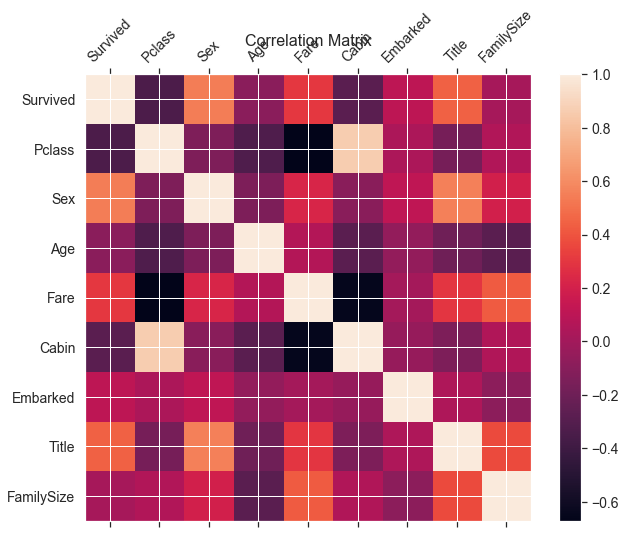

In [440]:
f = plt.figure(figsize=(10, 8))
plt.matshow(train.corr(), fignum=f.number)
plt.xticks(range(train.shape[1]), train.columns, fontsize=14, rotation=45)
plt.yticks(range(train.shape[1]), train.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

noticed correlation are correlated by accident, no changes needed

## Seeking for the best model

In [441]:
train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Embarked',
       'Title', 'FamilySize'],
      dtype='object')

In [442]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(train, train['Sex']):
    strat_train_set = train.loc[train_index]
    strat_test_set = train.loc[test_index]

In [443]:
strat_train_set["Sex"].value_counts() / len(strat_train_set)

0    0.647472
1    0.352528
Name: Sex, dtype: float64

In [444]:
strat_test_set["Sex"].value_counts() / len(strat_test_set)

0    0.648045
1    0.351955
Name: Sex, dtype: float64

In [445]:
# blunt force model check
# not any smart work here

columns = ['Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Embarked',
       'Title', 'FamilySize']

X_train = strat_train_set[columns]
Y_train = strat_train_set["Survived"]

X_test = strat_test_set[columns]
Y_test = strat_test_set["Survived"]


## 1st player – knn

In [446]:
from sklearn.neighbors import KNeighborsClassifier

X_train_knn = scaler.fit_transform(X_train.astype(np.float64))

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_knn, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [447]:
y_train_pred = knn_clf.predict(X_train_knn)

from sklearn.metrics import confusion_matrix

confusion_matrix(Y_train, y_train_pred)

array([[400,  45],
       [ 60, 207]])

We can notice that our model more often wrongly says that person died when he didnt THAN person survived when he didnt

In [448]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score

In [449]:
metrics_of_model(Y_train, y_train_pred)

Accuracy: 0.8525280898876404
Precision_score: 0.8214285714285714
Recall_score: 0.7752808988764045
F1_score: 0.7976878612716762


fine tune of model

In [450]:
from sklearn.model_selection import GridSearchCV

k_range = list(range(1,20))

param_grid = {
    'n_neighbors': k_range,
    "weights": ["uniform", "distance"],
    "metric":["eucledian","manhattan"]
}

grid_search = GridSearchCV(knn_clf, param_grid, verbose = 1, cv = 20, n_jobs = -1)
grid_search.fit(X_train_knn, Y_train)

Fitting 20 folds for each of 76 candidates, totalling 1520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 1520 out of 1520 | elapsed:    6.6s finished


GridSearchCV(cv=20, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'metric': ['eucledian', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [451]:
def metrics_of_model(y_train, y_train_pred):
    print(f"Accuracy: {accuracy_score(y_train, y_train_pred)}")
    print(f"Precision_score: {precision_score(y_train, y_train_pred)}")
    print(f"Recall_score: {recall_score(y_train, y_train_pred)}")
    print(f"F1_score: {f1_score(y_train, y_train_pred)}")

In [452]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_neighbors': k_range,
    "weights": ["uniform", "distance"],
}

rnd_search = RandomizedSearchCV(knn_clf, param_distributions=param_grid,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train_knn, Y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19],
                                        'weights': ['uniform', 'distance']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
       

In [453]:
metrics_of_model(Y_test, rnd_search.best_estimator_.predict(X_test_knn))

Accuracy: 0.7094972067039106
Precision_score: 0.6236559139784946
Recall_score: 0.7733333333333333
F1_score: 0.6904761904761905


In [454]:
X_test_knn = scaler.fit_transform(X_test.astype(np.float64))
metrics_of_model(Y_test, grid_search.best_estimator_.predict(X_test_knn))

Accuracy: 0.8156424581005587
Precision_score: 0.8181818181818182
Recall_score: 0.72
F1_score: 0.7659574468085107


In [455]:
confusion_matrix(Y_test, grid_search.best_estimator_.predict(X_test_knn))

array([[92, 12],
       [21, 54]])

In [456]:
metrics_of_model(Y_test, knn_clf.predict(X_test_knn))

Accuracy: 0.8156424581005587
Precision_score: 0.7837837837837838
Recall_score: 0.7733333333333333
F1_score: 0.7785234899328859


In [457]:
confusion_matrix(Y_test, knn_clf.predict(X_test_knn))

array([[88, 16],
       [17, 58]])

1. On the test set we figured that we achieved better results without fine tune of our model, althoug on the train part we saw quite exciting numbers with random search, although the result wasnt stable with test part.

# Final step will be – the best model will learn on the whole Train dataset

## 2 player – decisiontree

In [355]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, Y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [359]:
metrics_of_model(Y_train, tree_reg.predict(X_train).round())

Accuracy: 0.9058988764044944
Precision_score: 0.9424778761061947
Recall_score: 0.797752808988764
F1_score: 0.8640973630831642


In [366]:
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

 

# Create an scaler object
sc = StandardScaler()

# Create a pca object
pca = decomposition.PCA()

# Create a logistic regression object with an L2 penalty
decisiontree = tree.DecisionTreeClassifier()

# Create a pipeline of three steps. First, standardize the data.
# Second, tranform the data with PCA.
# Third, train a Decision Tree Classifier on the data.
pipe = Pipeline(steps=[
    #('sc', sc),
                       ('pca', pca),
                       ('decisiontree', decisiontree)])

# Create Parameter Space
# Create a list of a sequence of integers from 1 to 30 (the number of features in X + 1)
n_components = list(range(1,X_train.shape[1]+1,1))

# Create lists of parameter for Decision Tree Classifier
criterion = ['gini', 'entropy']
max_depth = [4,6,8,12]

# Create a dictionary of all the parameter options 
# Note has you can access the parameters of steps of a pipeline by using '__’
parameters = dict(pca__n_components=n_components,
                  decisiontree__criterion=criterion,
                  decisiontree__max_depth=max_depth)

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
clf = GridSearchCV(pipe, parameters)

# Fit the grid search
clf.fit(X_train, Y_train)

# View The Best Parameters
print('Best Criterion:', clf.best_estimator_.get_params()['decisiontree__criterion'])
print('Best max_depth:', clf.best_estimator_.get_params()['decisiontree__max_depth'])
print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
print(); print(clf.best_estimator_.get_params()['decisiontree'])

Best Criterion: gini
Best max_depth: 6
Best Number Of Components: 4

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [371]:
metrics_of_model(Y_test, clf.best_estimator_.predict(X_test))

Accuracy: 0.8435754189944135
Precision_score: 0.9272727272727272
Recall_score: 0.68
F1_score: 0.7846153846153845


In [372]:
metrics_of_model(Y_test, tree_reg.predict(X_test).round())

Accuracy: 0.7821229050279329
Precision_score: 0.8103448275862069
Recall_score: 0.6266666666666667
F1_score: 0.706766917293233


Best option was with using gridsearch, when testing on test set

# Other models will be tested in further versions, for now let's see how our best (decision tree will do)

In [373]:
from sklearn.externals import joblib

# засунуть после .fit()
joblib.dump(clf, "decision_tree_model.pkl")

/Users/admin/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['decision_tree_model.pkl']

In [404]:
y_predictions = clf.best_estimator_.predict(test[test.columns[1:]])

In [405]:
columns = ["PassengerId", "Survived"]
kaggle_upload = pd.DataFrame(columns=columns)

In [406]:
kaggle_upload["PassengerId"] = test["PassengerId"]
kaggle_upload["Survived"] = y_predictions

In [415]:
kaggle_upload.to_csv("kaggle_titanic_decision_tree.csv", index=False)

In [ ]:
# another attempt

In [458]:
test_knn = test[test.columns[1:]].copy()
test_knn = scaler.fit_transform(test_knn)

y_predictions = grid_search.best_estimator_.predict(test_knn)

In [459]:
columns = ["PassengerId", "Survived"]
kaggle_upload = pd.DataFrame(columns=columns)

In [460]:
kaggle_upload["PassengerId"] = test["PassengerId"]
kaggle_upload["Survived"] = y_predictions

In [461]:
kaggle_upload.to_csv("kaggle_titanic_knn.csv", index=False)